# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
import sys
sys.path.append("..")  # Adjust based on your directory structure

%load_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# %aimport afml

In [108]:
import warnings
import winsound
from datetime import timedelta, datetime as dt
from pprint import pprint
from pathlib import Path

import pandas_ta as ta
import talib
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from afml.backtest_statistics.reporting import (
    create_classification_report_image,
    meta_labelling_reports,
)

from afml.data_structures.bars import *
from afml.features import get_time_features, get_fractal_features
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    calculate_label_metrics,
    fixed_time_horizon,
    get_bins,
    get_bins_from_trend,
    get_events,
    triple_barrier_labels,
    get_trend_scanning_meta_labels,

)
from afml.strategies import (
    BaseStrategy,
    BollingerMeanReversionStrategy,
    MovingAverageCrossoverStrategy,
    TripleBarrierEvaluator,
    create_bollinger_features,
    get_entries,
)
from afml.util import (
    COMMODITIES,
    CLEAN_DATA_PATH,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    value_counts_data,
)
from afml.mt5.get_data import (
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
    verify_or_create_account_info,
)
from notebooks.training import train_meta_model, compare_roc_curves, meta_labelling_classification_reports

warnings.filterwarnings("ignore")
plt.style.use("dark_background")


In [3]:
from afml.cache import clear_afml_cache


clear_afml_cache()

## 1. Data Preparation

In [4]:
account = "FundedNext_STLR2_6K"
# account = login_mt5(account="FundedNext_STLR2_6K")
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date


def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict[timeframe]
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
        except FileNotFoundError:
            save_data_to_parquet(CLEAN_DATA_PATH, symbol, start_date, end_date, account)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [161]:
timeframe = "M5"
tick_bar_size = tick_bar_dict[timeframe]
bb_time_bars, bb_tick_bars = get_data(symbol, timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"
bb_df = bb_time_bars.loc[sample_start : sample_end]
bb_df0 = bb_tick_bars.loc[sample_start : sample_end]

Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


### Feature Engineering

In [191]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerMeanReversionStrategy(window=bb_period, num_std=bb_std)

lookback = 10
bb_feat = create_bollinger_features(bb_df, lookback, bb_period, bb_std)
bb_feat["side"] = bb_strategy.generate_signals(bb_df)
bb_feat.info()

Reloading 'afml.features.moving_averages'.
Reloading 'afml.strategies.bollinger_features'.
2025-08-30 20:10:39.877 | INFO     | afml.features.moving_averages:calculate_ma_differences:35 - 
Dropped features with correlation > 0.8: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_20', 'sma_diff_5_200', 'sma_diff_5_50']
Kept features: 
	['sma_diff_5_10', 'sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295657 entries, 2018-01-01 23:05:00 to 2021-12-31 23:00:00
Data columns (total 49 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rel_spread        295656 non-null  float32
 1   bb_bandwidth      295637 non-null  float32
 2   bb_percentage     295637 non-null  float64
 3   returns           295656 non-null  float32
 4   returns_5         295652 non-null  f

In [163]:
target_vol_params = dict(days=1, lookback=100)
tb_evaluator = TripleBarrierEvaluator(
    bb_strategy, bb_df, target_vol_params,
    target_vol_multiplier=1,
    filter_events=True,
    vertical_barrier_zero=True,
    on_crossover=True,
    )
pt_barrier, sl_barrier, time_horizon = (2, 1, 20)

2025-08-30 19:59:21.953 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-30 19:59:22.042 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 7,834 trade events generated by CUSUM filter.


### Fixed-Time Horizon Method

In [164]:
bb_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
bb_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_fh)

### Triple-Barrier Method

In [165]:
bb_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
bb_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_tbl)

In [166]:
print(f"Bollinger_w{bb_period}_std{bb_std}: \n")

bb_metrics_df = pd.DataFrame({
    "fixed_horizon": bb_events_fh_metrics,
    "triple_barrier": bb_events_tbl_metrics,
    })
bb_metrics_df

Bollinger_w20_std1.5: 



,fixed_horizon,triple_barrier
total_return,0.724101,0.442506
annualized_return,0.146205,0.096128
volatility,0.405758,0.377989
downside_volatility,0.275666,0.227723
sharpe_ratio,12.887154,9.347379
sortino_ratio,18.968848,15.515375
var_95,-0.002226,-0.002
cvar_95,-0.003281,-0.002784
skewness,0.337767,0.426003
kurtosis,4.533642,3.02738


### Trend-Scanning Method

In [167]:
from afml.filters.filters import cusum_filter
from afml.labeling.trend_scanning import get_trend_scanning_meta_labels
from afml.util.volatility import get_daily_vol


span = (5, 21)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(bb_df.close).mean()
t_events = cusum_filter(bb_df.close, thres)
side = bb_strategy.generate_signals(bb_df)
close = bb_df.close


bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_metrics = calculate_label_metrics(bb_df.index, side, bb_events_trend)

# bb_events_trend_mr = get_bins_from_trend(close, span, volatility_threshold_mr)
# bb_events_trend_mr = trend_meta_labels(bb_events_trend_mr, side, t_events, mean_reversion=True)
bb_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
bb_events_trend_metrics_mr = calculate_label_metrics(bb_df.index, side, bb_events_trend_mr)

print(f"bb_events_trend.shape: {bb_events_trend.shape}, bb_events_trend_mr.shape: {bb_events_trend_mr.shape}\n")
print(f"Bollinger_w{bb_period}_std{bb_std}_trend_scanning: \n")
bb_events_trend_metrics_all = pd.concat([bb_events_trend_metrics, bb_events_trend_metrics_mr], axis=1)
bb_events_trend_metrics_all.columns = ["trend_time", "trend_time_mr"]
bb_events_trend_metrics_all

bb_events_trend.shape: (9708, 4), bb_events_trend_mr.shape: (9708, 4)

Bollinger_w20_std1.5_trend_scanning: 



,trend_time,trend_time_mr
total_return,0.989336,0.464981
annualized_return,0.187899,0.100309
volatility,0.390722,0.295388
downside_volatility,0.283881,0.263371
sharpe_ratio,13.607675,9.996627
sortino_ratio,18.729055,11.211856
var_95,-0.00222,-0.001544
cvar_95,-0.003258,-0.002692
skewness,0.156996,0.395475
kurtosis,5.306702,14.829727


### Random Forest

In [192]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )



Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1146
           1       0.51      1.00      0.68      1201

    accuracy                           0.51      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.26      0.51      0.35      2347


Confusion Matrix:
[[   0 1146]
 [   0 1201]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52      1146
           1       0.50      0.41      0.45      1201

    accuracy                           0.49      2347
   macro avg       0.49      0.49      0.49      2347
weighted avg       0.49      0.49      0.49      2347


Confusion Matrix:
[[657 489]
 [707 494]]


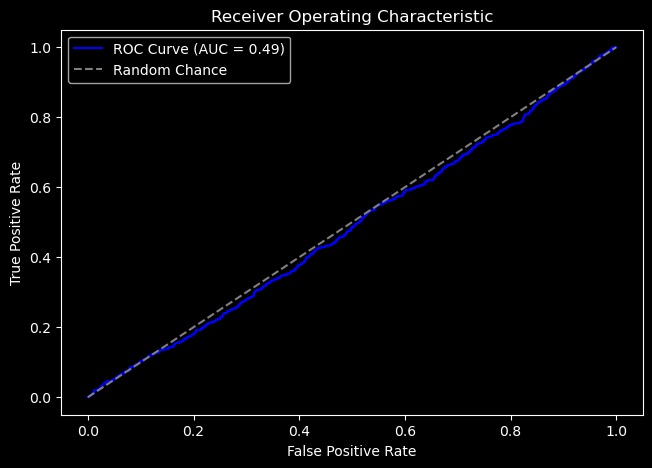

In [193]:
model_bb_fh = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_fh.index), labels=bb_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_fh.y_test, model_bb_fh.w_test, model_bb_fh.pred, model_bb_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2186
           1       0.07      1.00      0.13       161

    accuracy                           0.07      2347
   macro avg       0.03      0.50      0.06      2347
weighted avg       0.00      0.07      0.01      2347


Confusion Matrix:
[[   0 2186]
 [   0  161]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      2186
           1       0.14      0.65      0.23       161

    accuracy                           0.70      2347
   macro avg       0.55      0.68      0.52      2347
weighted avg       0.91      0.70      0.77      2347


Confusion Matrix:
[[1533  653]
 [  56  105]]


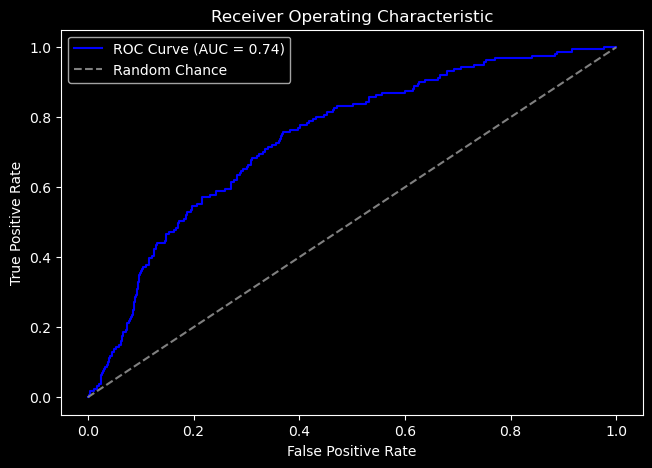

In [194]:
model_bb_tbl = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_tbl.index), labels=bb_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_tbl.y_test, model_bb_tbl.w_test, model_bb_tbl.pred, model_bb_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1584
           1       0.46      1.00      0.63      1325

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1584]
 [   0 1325]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.80      0.36      0.50      1584
           1       0.54      0.89      0.67      1325

    accuracy                           0.60      2909
   macro avg       0.67      0.63      0.58      2909
weighted avg       0.68      0.60      0.58      2909


Confusion Matrix:
[[ 568 1016]
 [ 142 1183]]


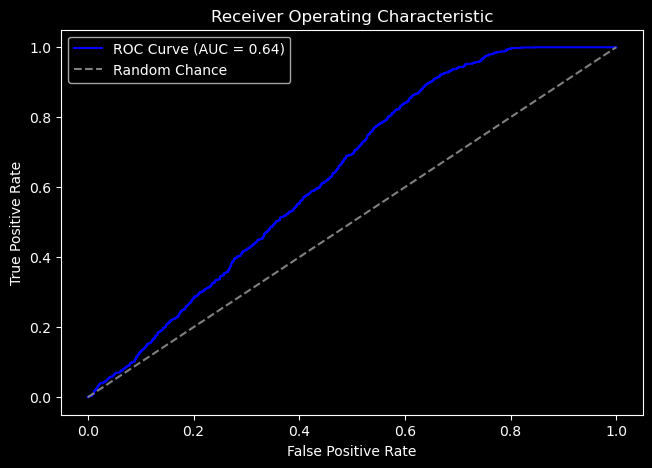

In [195]:
model_bb_trend = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_trend.index), labels=bb_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend.y_test, model_bb_trend.w_test, model_bb_trend.pred, model_bb_trend.prob, plot_roc=True
    )

Trend-Scanning Mean-Reversion Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2688
           1       0.41      0.83      0.55       221

    accuracy                           0.90      2909
   macro avg       0.70      0.87      0.75      2909
weighted avg       0.94      0.90      0.91      2909


Confusion Matrix:
[[2427  261]
 [  38  183]]


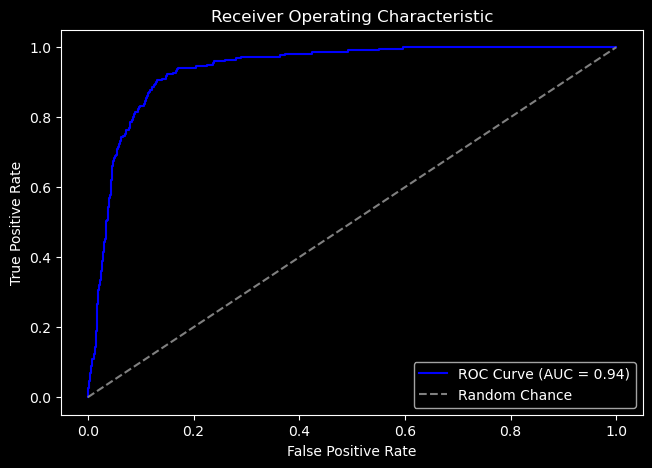

In [196]:
model_bb_trend_mr = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_trend_mr.index), labels=bb_events_trend_mr)
print("Trend-Scanning Mean-Reversion Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend_mr.y_test, model_bb_trend_mr.w_test, model_bb_trend_mr.pred, model_bb_trend_mr.prob, plot_roc=True
    )

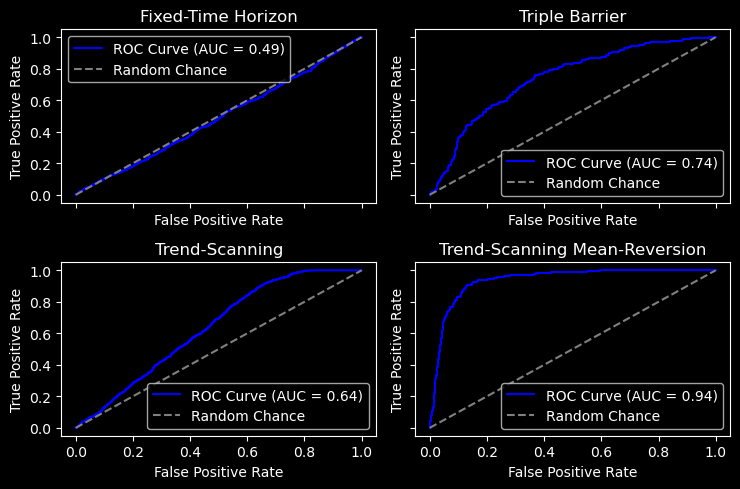

In [197]:
titles = ["Fixed-Time Horizon", "Triple Barrier", "Trend-Scanning", "Trend-Scanning Mean-Reversion"]
bb_models = [model_bb_fh, model_bb_tbl, model_bb_trend, model_bb_trend_mr]
bb_roc = compare_roc_curves(bb_models, titles)
bb_roc.savefig("reports/bollinger_roc_comparison.png")

In [174]:
meta_labelling_classification_reports(model_data=model_bb_fh, title="Fixed-Time Horizon", output_filename="bb_fixed_time")
meta_labelling_classification_reports(model_data=model_bb_fh, title="Triple Barrier", output_filename="bb_triple_barrier")
meta_labelling_classification_reports(model_data=model_bb_fh, title="Trend-Scanning", output_filename="bb_trend_scanning")
meta_labelling_classification_reports(model_data=model_bb_fh, title="Trend-Scanning (Mean-Reversion)", output_filename="bb_trend_scanning_mr")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1146
           1       0.51      1.00      0.68      1201

    accuracy                           0.51      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.26      0.51      0.35      2347


Confusion Matrix:
[[   0 1146]
 [   0 1201]]

Accuracy:
0.5117170856412442

Successfully generated and saved 'bb_fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.48      0.57      0.52      1146
           1       0.50      0.41      0.45      1201

    accuracy                           0.49      2347
   macro avg       0.49      0.49      0.49      2347
weighted avg       0.49      0.49      0.49      2347


Confusion Matrix:
[[657 489]
 [707 494]]

Accuracy:
0.4904132935662548

Successfully generated and saved 'bb_fixed_time_meta_clf_r

## 3. Moving Average Crossover Strategy

In [252]:
ma_timeframe = "M30"
tick_bar_size = tick_bar_dict[ma_timeframe]
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"
ma_df = ma_time_bars.loc[sample_start : sample_end]
ma_df0 = ma_tick_bars.loc[sample_start : sample_end]

fast_window, slow_window = 20, 50
ma_strategy = MovingAverageCrossoverStrategy(fast_window, slow_window)
pt_barrier, sl_barrier, time_horizon = (4, 2, 200)
target_vol_params = dict(days=1, lookback=100)
vol_multiplier = 0.5
tb_evaluator = TripleBarrierEvaluator(
    ma_strategy, ma_df, target_vol_params,
    target_vol_multiplier=vol_multiplier,
    filter_events=True,
    vertical_barrier_zero=False,
    )

Loaded EURUSD_M30_tick-1000_2018-01-01-2024-12-31.parq
Loaded EURUSD_M30_time_2018-01-01-2024-12-31.parq
2025-08-30 20:38:47.522 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-30 20:38:47.607 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 5,988 trade events generated by CUSUM filter.


### Feature Engineering

In [253]:
from afml.features.fracdiff import fracdiff_optimal, frac_diff_ffd


close_ffd, d, _ = fracdiff_optimal(ma_df.close, verbose=True)
ma_df_ffd = frac_diff_ffd(ma_df, d)

In [254]:
bb_feat = create_bollinger_features(ma_df, lookback_window=fast_window, bb_period=20, bb_std=2)
span = (5, slow_window)

trend_feat = get_bins_from_trend(ma_df.close, span, volatility_threshold=0.1, lookforward=False)
trend_feat_cols = {k: f"trend_{k}" for k in ['window', 'slope', 't_value', 'rsquared']}
trend_feat.rename(columns=trend_feat_cols, inplace=True)
trend_feat = trend_feat[trend_feat_cols.values()]

trend_feat_ffd = get_bins_from_trend(close_ffd, span, volatility_threshold=0.1, lookforward=False, use_log=False)
trend_feat_ffd.rename(columns=trend_feat_cols, inplace=True)
trend_feat_ffd = trend_feat_ffd[trend_feat_cols.values()]

time_feat = get_time_features(ma_df, ma_timeframe, n_terms=1)

vol_series = ma_df.ta.atr(14)
fractal_feat = get_fractal_features(ma_df, vol_series, ma_period=fast_window)

ma_feat = pd.concat([np.log(close), trend_feat, time_feat, fractal_feat], axis=1).shift(1)
ma_feat = ma_feat.join(bb_feat)
ma_feat = optimize_dtypes(ma_feat)

ma_feat_ffd = pd.concat([close_ffd, trend_feat_ffd, time_feat, fractal_feat], axis=1).shift(1)
ma_feat_ffd = ma_feat_ffd.join(bb_feat)
ma_feat_ffd = optimize_dtypes(ma_feat_ffd)

# feat_engine = ForexFeatureEngine(pair_name=symbol)
# ma_feat = feat_engine.calculate_all_features(ma_df)

ma_feat["side"] = ma_strategy.generate_signals(ma_df)
ma_feat_ffd["side"] = ma_feat["side"]
ma_feat.info()

2025-08-30 20:38:50.637 | INFO     | afml.features.moving_averages:calculate_ma_differences:35 - 
Dropped features with correlation > 0.8: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_20', 'sma_diff_5_200', 'sma_diff_5_50']
Kept features: 
	['sma_diff_5_10', 'sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']
Memory usage reduced from 22.56 MB to 16.17 MB (28.3% reduction)
Memory usage reduced from 22.75 MB to 16.17 MB (28.9% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 84 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   close                    49279 non-null  float32
 1   trend_window             49231 non-null  float32
 2   trend_slope              49231 non-null  float32
 3   trend_t_value   

### Fixed-Time Horizon Method

In [255]:
ma_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
ma_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_fh)
ma_events_fh_metrics

total_return                           0.898958
annualized_return                      0.174281
volatility                              1.10215
downside_volatility                    0.720549
sharpe_ratio                           1.753298
sortino_ratio                          2.681839
var_95                                -0.015042
cvar_95                               -0.021589
skewness                               0.005453
kurtosis                               2.034684
probabilistic_sharpe_ratio             0.888705
pos_concentration                      0.000265
neg_concentration                      0.000262
time_concentration                     0.003805
max_drawdown                           0.630101
avg_drawdown                           0.310787
drawdown_duration             111 days 21:30:00
ulcer_index                            0.388294
calmar_ratio                           0.276592
num_trades                                 5965
trades_per_year                         

### Triple-Barrier Method

In [256]:
ma_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
ma_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_tbl)
ma_events_tbl_metrics

total_return                          8.782924
annualized_return                     0.770625
volatility                            0.607451
downside_volatility                   0.166637
sharpe_ratio                          8.035448
sortino_ratio                        29.292077
var_95                               -0.005755
cvar_95                              -0.006942
skewness                               0.84445
kurtosis                             -0.016089
probabilistic_sharpe_ratio                 1.0
pos_concentration                     0.000119
neg_concentration                      0.00005
time_concentration                    0.003776
max_drawdown                          0.509294
avg_drawdown                          0.047286
drawdown_duration             18 days 00:07:24
ulcer_index                           0.091154
calmar_ratio                          1.513124
num_trades                                5985
trades_per_year                           1498
win_rate     

In [257]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    })
ma_metrics_df

MACrossover_fast20_slow50: 



,fixed_horizon,triple_barrier
total_return,0.898958,8.782924
annualized_return,0.174281,0.770625
volatility,1.10215,0.607451
downside_volatility,0.720549,0.166637
sharpe_ratio,1.753298,8.035448
sortino_ratio,2.681839,29.292077
var_95,-0.015042,-0.005755
cvar_95,-0.021589,-0.006942
skewness,0.005453,0.84445
kurtosis,2.034684,-0.016089


### Trend-Scanning Method

In [258]:
span = (5, time_horizon)
volatility_threshold = 0.1

thres = get_daily_vol(ma_df.close).mean() * vol_multiplier
t_events = cusum_filter(ma_df.close, thres)
print(f"t_events: {len(t_events):,}")

side = ma_strategy.generate_signals(ma_df)
close = ma_df.close

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_metrics = calculate_label_metrics(ma_df.index, side, ma_events_trend)

ma_events_trend_ffd = get_trend_scanning_meta_labels(close_ffd, side, t_events, span, volatility_threshold, use_log=False)

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    "trend_scanning": ma_events_trend_metrics,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

t_events: 5,993
MACrossover_fast20_slow50:
ma_events_trend.shape: (5970, 4)



,fixed_horizon,triple_barrier,trend_scanning
total_return,0.898958,8.782924,3.986432
annualized_return,0.174281,0.770625,0.495156
volatility,1.10215,0.607451,1.156369
downside_volatility,0.720549,0.166637,0.724708
sharpe_ratio,1.753298,8.035448,3.447821
sortino_ratio,2.681839,29.292077,5.501458
var_95,-0.015042,-0.005755,-0.015248
cvar_95,-0.021589,-0.006942,-0.022259
skewness,0.005453,0.84445,-0.026077
kurtosis,2.034684,-0.016089,1.466651


### Random Forest

In [259]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       877
           1       0.51      1.00      0.67       907

    accuracy                           0.51      1784
   macro avg       0.25      0.50      0.34      1784
weighted avg       0.26      0.51      0.34      1784


Confusion Matrix:
[[  0 877]
 [  0 907]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.49      0.80      0.61       877
           1       0.49      0.18      0.27       907

    accuracy                           0.49      1784
   macro avg       0.49      0.49      0.44      1784
weighted avg       0.49      0.49      0.43      1784


Confusion Matrix:
[[704 173]
 [741 166]]


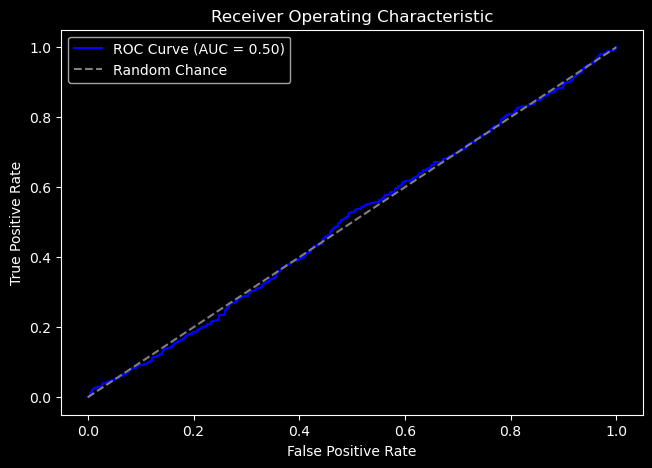

In [260]:
model_ma_fh = train_meta_model(model=rf, features=ma_feat.reindex(ma_events_fh.index), labels=ma_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_fh.y_test, model_ma_fh.w_test, model_ma_fh.pred, model_ma_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1181
           1       0.34      1.00      0.51       609

    accuracy                           0.34      1790
   macro avg       0.17      0.50      0.25      1790
weighted avg       0.12      0.34      0.17      1790


Confusion Matrix:
[[   0 1181]
 [   0  609]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.67      0.92      0.78      1181
           1       0.44      0.12      0.19       609

    accuracy                           0.65      1790
   macro avg       0.56      0.52      0.48      1790
weighted avg       0.59      0.65      0.58      1790


Confusion Matrix:
[[1085   96]
 [ 533   76]]


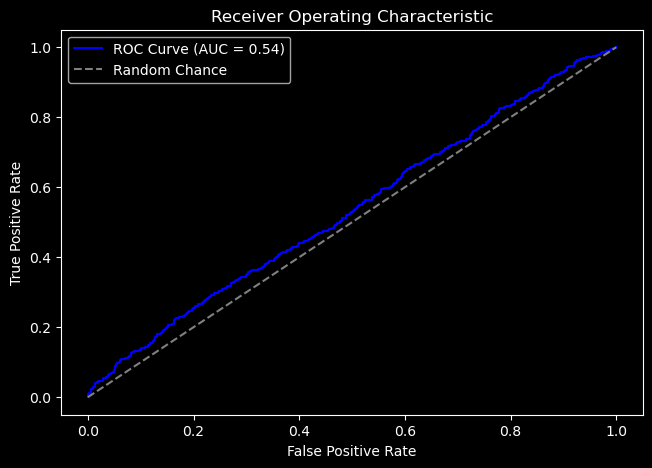

In [261]:
model_ma_tbl = train_meta_model(model=rf, features=ma_feat.reindex(ma_events_tbl.index), labels=ma_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_tbl.y_test, model_ma_tbl.w_test, model_ma_tbl.pred, model_ma_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.45      1.00      0.62       804

    accuracy                           0.45      1784
   macro avg       0.23      0.50      0.31      1784
weighted avg       0.20      0.45      0.28      1784


Confusion Matrix:
[[  0 980]
 [  0 804]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.57      0.84      0.68       980
           1       0.54      0.23      0.32       804

    accuracy                           0.56      1784
   macro avg       0.55      0.53      0.50      1784
weighted avg       0.55      0.56      0.52      1784


Confusion Matrix:
[[823 157]
 [623 181]]


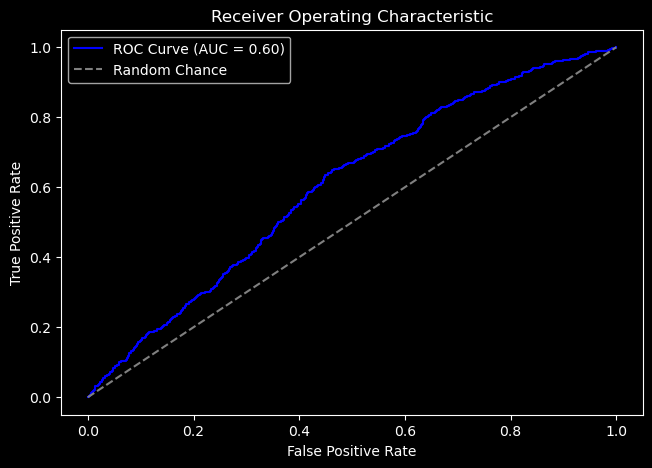

In [262]:
model_ma_trend = train_meta_model(model=rf, features=ma_feat.reindex(ma_events_trend.index), labels=ma_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_trend.y_test, model_ma_trend.w_test, model_ma_trend.pred, model_ma_trend.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       924
           1       0.44      1.00      0.61       728

    accuracy                           0.44      1652
   macro avg       0.22      0.50      0.31      1652
weighted avg       0.19      0.44      0.27      1652


Confusion Matrix:
[[  0 924]
 [  0 728]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.58      0.81      0.67       924
           1       0.51      0.26      0.34       728

    accuracy                           0.56      1652
   macro avg       0.55      0.53      0.51      1652
weighted avg       0.55      0.56      0.53      1652


Confusion Matrix:
[[745 179]
 [541 187]]


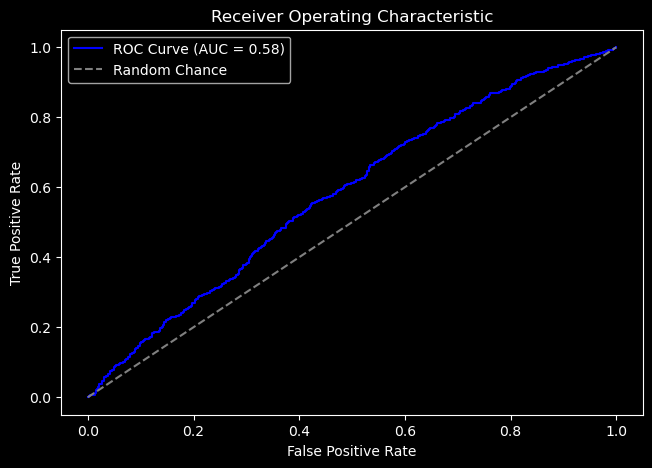

In [263]:
model_ma_trend_ffd = train_meta_model(model=rf, features=ma_feat_ffd.reindex(ma_events_trend_ffd.index), labels=ma_events_trend_ffd)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_trend_ffd.y_test, model_ma_trend_ffd.w_test, model_ma_trend_ffd.pred, model_ma_trend_ffd.prob, plot_roc=True
    )

In [264]:
dirpath = "reports"
meta_labelling_classification_reports(model_data=model_ma_fh, title="Fixed-Time Horizon", output_filename=f"{dirpath}/ma_fixed_time")
meta_labelling_classification_reports(model_data=model_ma_tbl, title="Triple Barrier", output_filename=f"{dirpath}/ma_triple_barrier")
meta_labelling_classification_reports(model_data=model_ma_trend, title="Trend-Scanning", output_filename=f"{dirpath}/ma_trend_scanning")
meta_labelling_classification_reports(model_data=model_ma_trend_ffd, title="Trend-Scanning (with Fractionally Differentiation)", output_filename=f"{dirpath}/ma_trend_scanning_ffd")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       877
           1       0.51      1.00      0.67       907

    accuracy                           0.51      1784
   macro avg       0.25      0.50      0.34      1784
weighted avg       0.26      0.51      0.34      1784


Confusion Matrix:
[[  0 877]
 [  0 907]]

Accuracy:
0.5084080717488789

Successfully generated and saved 'reports/ma_fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.49      0.80      0.61       877
           1       0.49      0.18      0.27       907

    accuracy                           0.49      1784
   macro avg       0.49      0.49      0.44      1784
weighted avg       0.49      0.49      0.43      1784


Confusion Matrix:
[[704 173]
 [741 166]]

Accuracy:
0.4876681614349776

Successfully generated and saved 'reports/ma_fixed_tim